<a href="https://colab.research.google.com/github/joeyeuron/Case-Study-CE880/blob/main/Final_Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
from pandas import read_csv
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

# Data Loading and Exploration

In [2]:
from google.colab import files #loading files via colab
uploaded = files.upload()

Saving loan_data.xlsx to loan_data (1).xlsx


### Load dataset using pandas

In [3]:
excel_file = pd.ExcelFile('loan_data.xlsx')
df = excel_file.parse(excel_file.sheet_names[0])

###Perform Exploratory Data Analysis (EDA)

In [4]:
print(df.head())

  Gender Married Dependents     Education Self_Employed  Applicant_Income  \
0   Male      No          0      Graduate            No            584900   
1   Male     Yes          1      Graduate            No            458300   
2   Male     Yes          0      Graduate           Yes            300000   
3   Male     Yes          0  Not Graduate            No            258300   
4   Male      No          0      Graduate            No            600000   

   Coapplicant_Income  Loan_Amount   Term  Credit_History   Area Status  
0                 0.0     15000000  360.0             1.0  Urban      Y  
1            150800.0     12800000  360.0             1.0  Rural      N  
2                 0.0      6600000  360.0             1.0  Urban      Y  
3            235800.0     12000000  360.0             1.0  Urban      Y  
4                 0.0     14100000  360.0             1.0  Urban      Y  


In [5]:
#Basic information about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              601 non-null    object 
 1   Married             611 non-null    object 
 2   Dependents          599 non-null    object 
 3   Education           614 non-null    object 
 4   Self_Employed       582 non-null    object 
 5   Applicant_Income    614 non-null    int64  
 6   Coapplicant_Income  614 non-null    float64
 7   Loan_Amount         614 non-null    int64  
 8   Term                600 non-null    float64
 9   Credit_History      564 non-null    float64
 10  Area                614 non-null    object 
 11  Status              614 non-null    object 
dtypes: float64(3), int64(2), object(7)
memory usage: 57.7+ KB
None


In [6]:
#Statistical summary of the numerical columns
print(df.describe())

       Applicant_Income  Coapplicant_Income   Loan_Amount       Term  \
count      6.140000e+02        6.140000e+02  6.140000e+02  600.00000   
mean       5.403459e+05        1.621246e+05  1.414104e+07  342.00000   
std        6.109042e+05        2.926248e+05  8.815682e+06   65.12041   
min        1.500000e+04        0.000000e+00  0.000000e+00   12.00000   
25%        2.877500e+05        0.000000e+00  9.800000e+06  360.00000   
50%        3.812500e+05        1.188500e+05  1.250000e+07  360.00000   
75%        5.795000e+05        2.297250e+05  1.647500e+07  360.00000   
max        8.100000e+06        4.166700e+06  7.000000e+07  480.00000   

       Credit_History  
count      564.000000  
mean         0.842199  
std          0.364878  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          1.000000  
max          1.000000  


In [7]:
#Distribution of the target variable 'Status'
print(df['Status'].value_counts())

Y    422
N    192
Name: Status, dtype: int64


##Data Preprocessing

In [8]:
#Missing Values
print(df.isnull().sum())

Gender                13
Married                3
Dependents            15
Education              0
Self_Employed         32
Applicant_Income       0
Coapplicant_Income     0
Loan_Amount            0
Term                  14
Credit_History        50
Area                   0
Status                 0
dtype: int64


###Handled missing values

In [9]:
# Replacing missing values with mode for respective columns
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
df['Married'].fillna(df['Married'].mode()[0], inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace=True)
df['Term'].fillna(df['Term'].mean(), inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)


###Encoded categorical variables

In [10]:
# Converting 'Dependents' column to strings
df['Dependents'] = df['Dependents'].astype(str)

# Using OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

#Categorical columns for one-hot encoding (excluding 'Status')
categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Area']

onehot_encoder = OneHotEncoder()
encoded_features = onehot_encoder.fit_transform(df[categorical_columns])
feature_names = onehot_encoder.get_feature_names_out(input_features=categorical_columns)
df_encoded = pd.concat([df.drop(categorical_columns, axis=1), pd.DataFrame(encoded_features.toarray(), columns=feature_names)], axis=1)



### Data Visualization

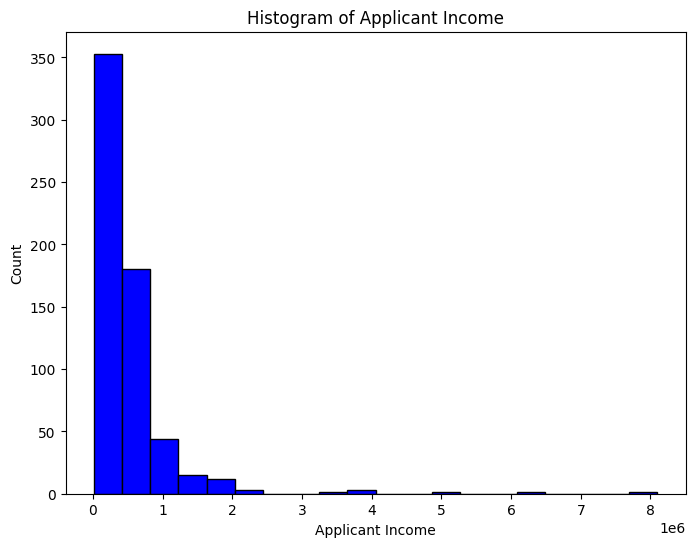

In [11]:
plt.figure(figsize=(8, 6))
plt.hist(df_encoded['Applicant_Income'], bins=20, color='blue', edgecolor='black')
plt.xlabel('Applicant Income')
plt.ylabel('Count')
plt.title('Histogram of Applicant Income')
plt.show()

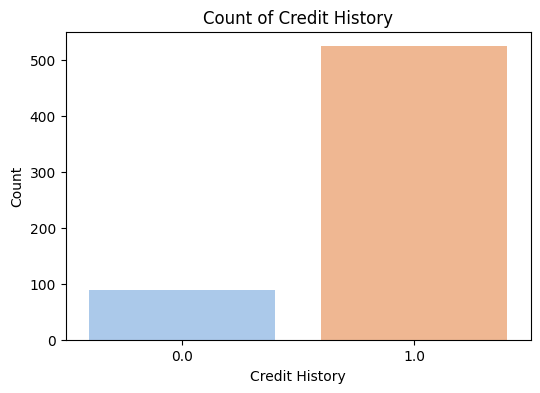

In [12]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Credit_History', data=df_encoded, palette='pastel')
plt.xlabel('Credit History')
plt.ylabel('Count')
plt.title('Count of Credit History')
plt.show()

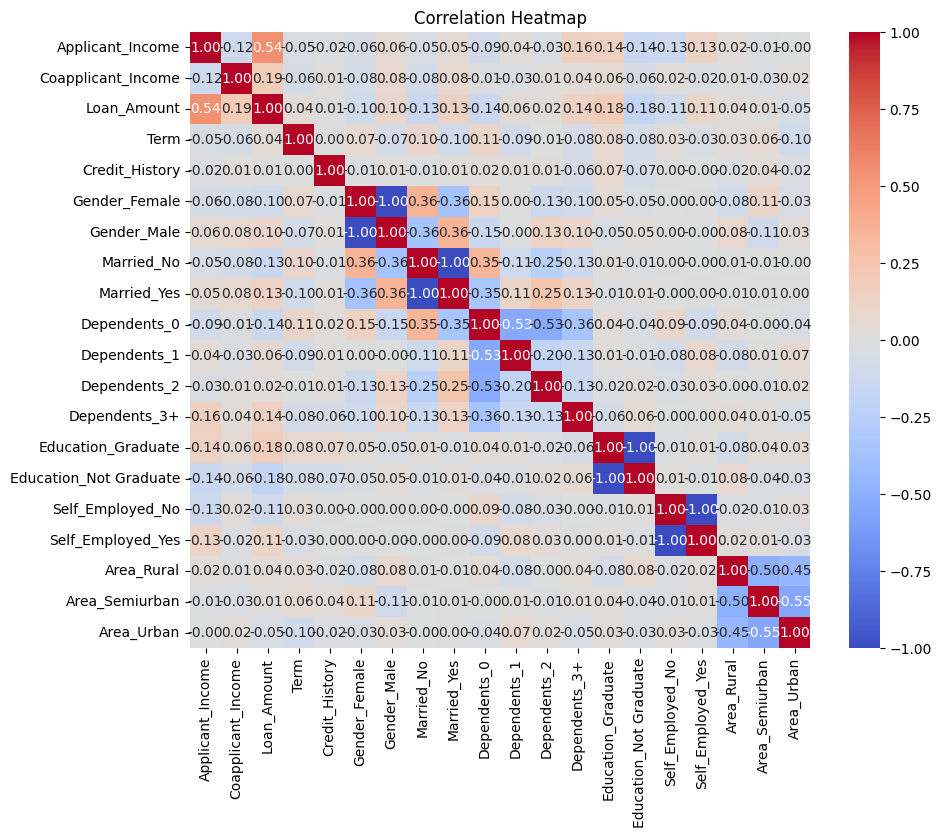

In [13]:
plt.figure(figsize=(10, 8))
corr_matrix = df_encoded.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

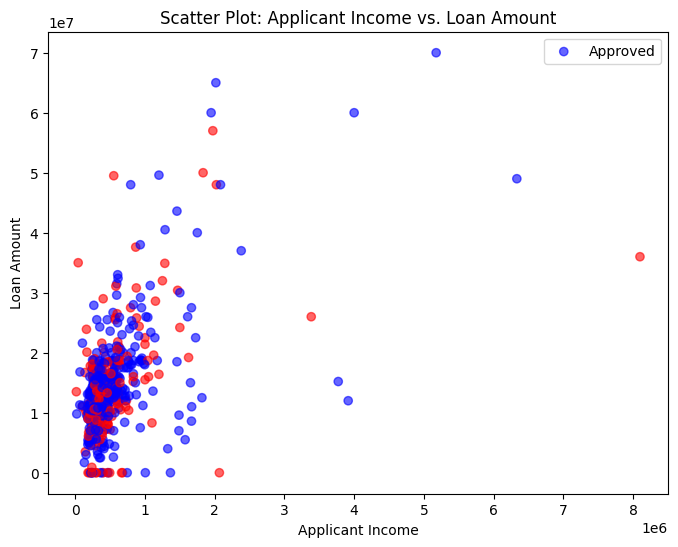

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(df_encoded['Applicant_Income'], df_encoded['Loan_Amount'], c=df_encoded['Status'].map({'Y': 'blue', 'N': 'red'}), alpha=0.6)
plt.xlabel('Applicant Income')
plt.ylabel('Loan Amount')
plt.title('Scatter Plot: Applicant Income vs. Loan Amount')
plt.legend(['Approved', 'Not Approved'])
plt.show()

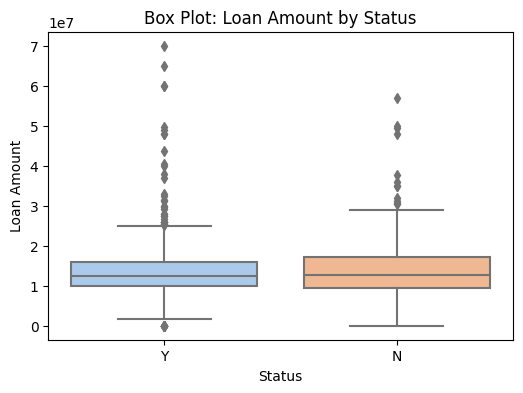

In [15]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='Status', y='Loan_Amount', data=df_encoded, palette='pastel')
plt.xlabel('Status')
plt.ylabel('Loan Amount')
plt.title('Box Plot: Loan Amount by Status')
plt.show()

# Data Splitting

In [16]:
# Splitting features (X) and the target variable (y)
X = df_encoded.drop('Status', axis=1)
y = df_encoded['Status']

# Splitting data into training (80%), validation (10%), and test sets (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



# Model Selection and Training

### Scaling feature Data for Model

In [17]:

scaler = StandardScaler()

# Fitting the scaler on the training data and transforming both training and validation data
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Scaling the test data using the same scaler used for training data
X_test_scaled = scaler.transform(X_test)


###Initialized classification models

In [18]:
svm_model = SVC(probability=True)
rf_model = RandomForestClassifier()
knn_model = KNeighborsClassifier()
gb_model = GradientBoostingClassifier()
nb_model = GaussianNB()

###Defined parameter grids for grid search to tune hyperparameters

In [19]:
# Defining parameter grids for grid search
svm_param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': [0.1, 1, 10]
}

rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

knn_param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7]
}

nb_param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
}

# Listing of models and their respective parameter grids
models = [svm_model, rf_model, knn_model, gb_model, nb_model]
param_grids = [svm_param_grid, rf_param_grid, knn_param_grid, gb_param_grid, nb_param_grid]
model_names = ['SVM', 'Random Forest', 'KNN', 'Gradient Boosting', 'Naive Bayes']


###Selection of best model

In [20]:
best_models = []  # To store the best models after grid search

# Looping over each model and its corresponding parameter grid
for model, param_grid, model_name in zip(models, param_grids, model_names):
    # Initialiing GridSearchCV with each model, parameter grid, and 5-fold cross-validation
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1') # Selection based on F1 score

    # Fit the GridSearchCV object to the training data
    grid_search.fit(X_train_scaled, y_train)

    # Retrieivng best model and its hyperparameters from the grid search
    best_model = grid_search.best_estimator_
    best_models.append(best_model)
    best_hyperparameters = grid_search.best_params_

    # Printing the best hyperparameters for each current model
    print(f"Best Hyperparameters for {model_name}:")
    print(best_hyperparameters)


Best Hyperparameters for SVM:
{'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
Best Hyperparameters for Random Forest:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Hyperparameters for KNN:
{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best Hyperparameters for Gradient Boosting:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best Hyperparameters for Naive Bayes:
{'var_smoothing': 1e-09}


#Model Evaluation on Validation Set

###Evaluated each best model on the validation set

Classification Report - SVM Model:
              precision    recall  f1-score   support

           N       0.90      0.47      0.62        19
           Y       0.80      0.98      0.88        42

    accuracy                           0.82        61
   macro avg       0.85      0.72      0.75        61
weighted avg       0.83      0.82      0.80        61



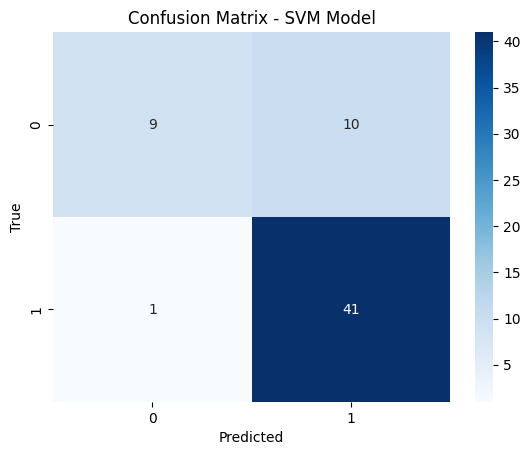

Classification Report - Random Forest Model:
              precision    recall  f1-score   support

           N       0.82      0.47      0.60        19
           Y       0.80      0.95      0.87        42

    accuracy                           0.80        61
   macro avg       0.81      0.71      0.73        61
weighted avg       0.81      0.80      0.79        61



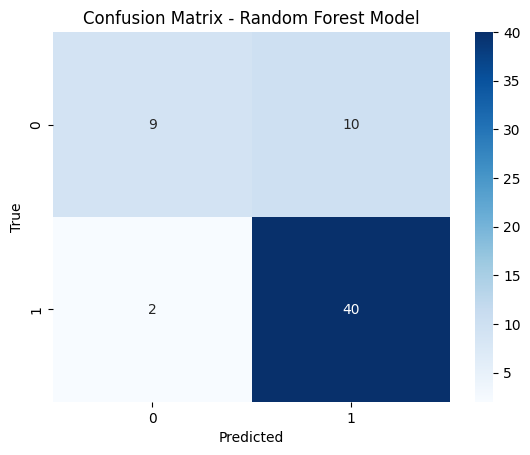

Classification Report - KNN Model:
              precision    recall  f1-score   support

           N       0.58      0.37      0.45        19
           Y       0.76      0.88      0.81        42

    accuracy                           0.72        61
   macro avg       0.67      0.62      0.63        61
weighted avg       0.70      0.72      0.70        61



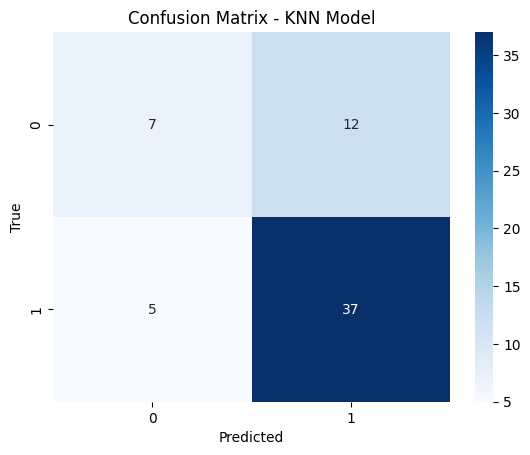

Classification Report - Gradient Boosting Model:
              precision    recall  f1-score   support

           N       0.82      0.47      0.60        19
           Y       0.80      0.95      0.87        42

    accuracy                           0.80        61
   macro avg       0.81      0.71      0.73        61
weighted avg       0.81      0.80      0.79        61



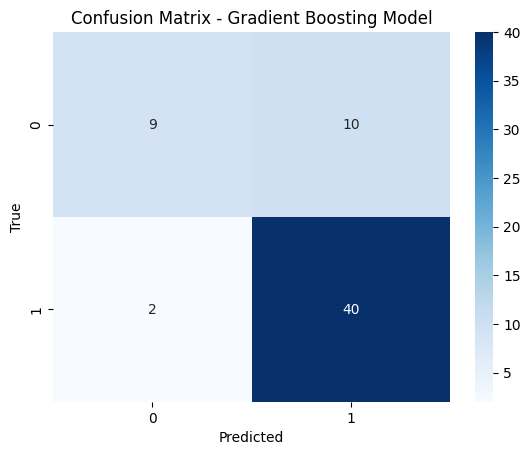

Classification Report - Naive Bayes Model:
              precision    recall  f1-score   support

           N       0.82      0.47      0.60        19
           Y       0.80      0.95      0.87        42

    accuracy                           0.80        61
   macro avg       0.81      0.71      0.73        61
weighted avg       0.81      0.80      0.79        61



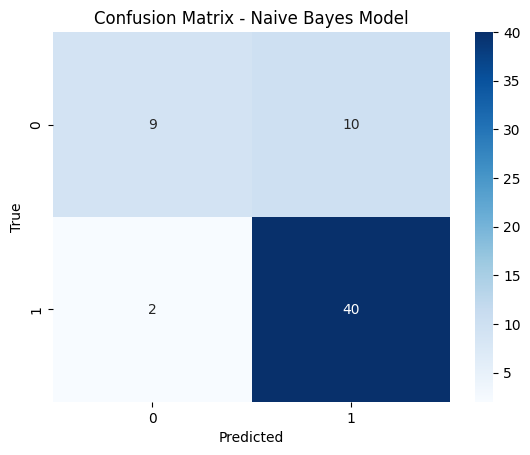

In [21]:
# Lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Iteration over each best model
for best_model, model_name in zip(best_models, model_names):
    # Predict on the validation set
    y_pred_val = best_model.predict(X_val_scaled)

    # Calculating and storing evaluation metrics
    accuracy_scores.append(np.round(best_model.score(X_val_scaled, y_val), 3))
    precision_scores.append(np.round(precision_score(y_val, y_pred_val, pos_label='Y'), 3))
    recall_scores.append(np.round(recall_score(y_val, y_pred_val, pos_label='Y'), 3))
    f1_scores.append(np.round(f1_score(y_val, y_pred_val, pos_label='Y'), 3))

    # Print classification report
    print(f"Classification Report - {model_name} Model:")
    print(classification_report(y_val, y_pred_val, target_names=['N', 'Y']))

    # Confusion matrix heatmap
    cm = confusion_matrix(y_val, y_pred_val)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name} Model')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


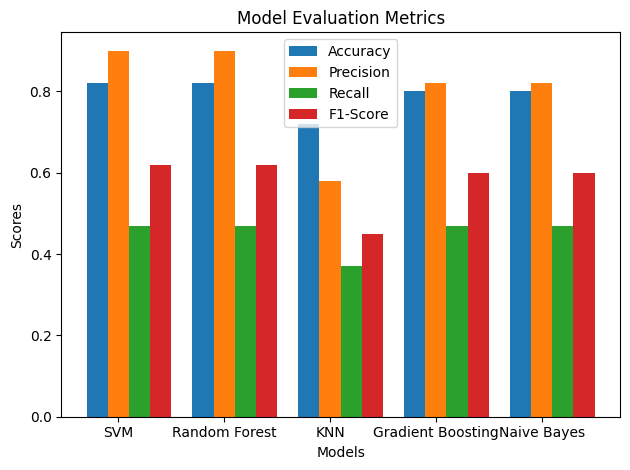

In [22]:
# List of model names
model_names = ['SVM', 'Random Forest', 'KNN', 'Gradient Boosting', 'Naive Bayes']

# List of corresponding metrics
accuracy_scores = [0.82, 0.82, 0.72, 0.80, 0.80]
precision_scores = [0.90, 0.90, 0.58, 0.82, 0.82]
recall_scores = [0.47, 0.47, 0.37, 0.47, 0.47]
f1_scores = [0.62, 0.62, 0.45, 0.60, 0.60]

# Setting positions for the bars
x = np.arange(len(model_names))
width = 0.2

# Creating bar plots for each metric
plt.bar(x - width, accuracy_scores, width, label='Accuracy')
plt.bar(x, precision_scores, width, label='Precision')
plt.bar(x + width, recall_scores, width, label='Recall')
plt.bar(x + 2 * width, f1_scores, width, label='F1-Score')

# Setting labels and title
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Evaluation Metrics')
plt.xticks(x, model_names)
plt.legend()

# Displaying the plot
plt.tight_layout()
plt.show()



#Model Comparison using ROC AUC

In [23]:
# Initializing empty lists to store mean ROC AUC scores for each model
mean_roc_auc_scores = []

# Performing cross-validation for each model
for model in models:
    roc_auc_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    mean_roc_auc_scores.append(np.mean(roc_auc_scores))

# Displaying the mean ROC AUC scores for each model
for model_name, roc_auc in zip(model_names, mean_roc_auc_scores):
    print(f"Model: {model_name}")
    print(f"Mean ROC AUC Score: {roc_auc}")
    print("=============================")


Model: SVM
Mean ROC AUC Score: 0.7846481661130219
Model: Random Forest
Mean ROC AUC Score: 0.7924719502993601
Model: KNN
Mean ROC AUC Score: 0.67795847174452
Model: Gradient Boosting
Mean ROC AUC Score: 0.7534103781442612
Model: Naive Bayes
Mean ROC AUC Score: 0.7564197313108153


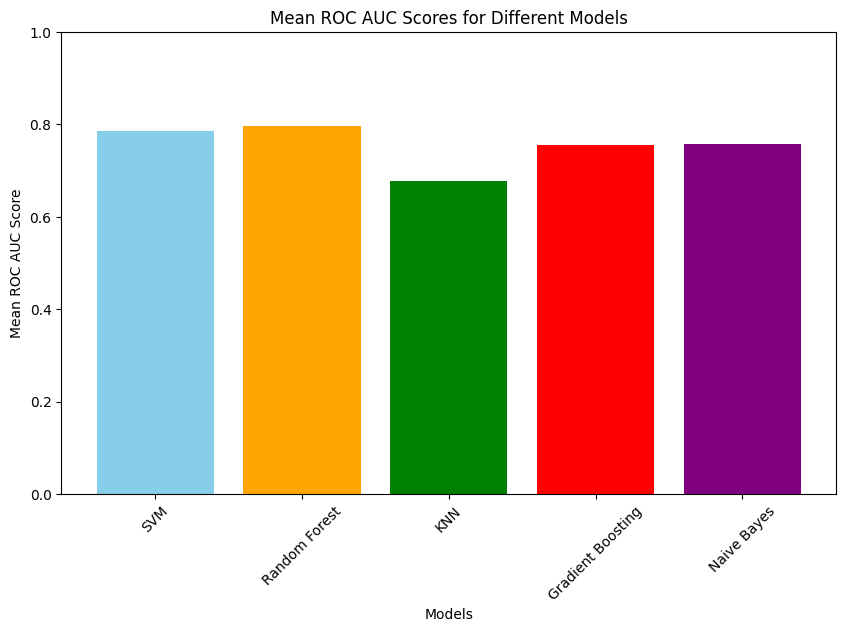

In [24]:
# Mean ROC AUC scores from cross-validation
mean_roc_auc_scores = [0.7846481661130219, 0.7955742716876857, 0.67795847174452, 0.7553687616975825, 0.7564197313108153]
model_names = ['SVM', 'Random Forest', 'KNN', 'Gradient Boosting', 'Naive Bayes']

# Bar plot
plt.figure(figsize=(10, 6))
plt.bar(model_names, mean_roc_auc_scores, color= ['skyblue', 'orange', 'green', 'red', 'purple'])
plt.xlabel('Models')
plt.ylabel('Mean ROC AUC Score')
plt.title('Mean ROC AUC Scores for Different Models')
plt.ylim([0, 1])
plt.xticks(rotation=45)
plt.show()


#Best Model Evaluation on Test Set

Classification Report - Best Random Forest Model (Test Set):
              precision    recall  f1-score   support

           N       0.91      0.42      0.57        24
           Y       0.73      0.97      0.83        38

    accuracy                           0.76        62
   macro avg       0.82      0.70      0.70        62
weighted avg       0.80      0.76      0.73        62



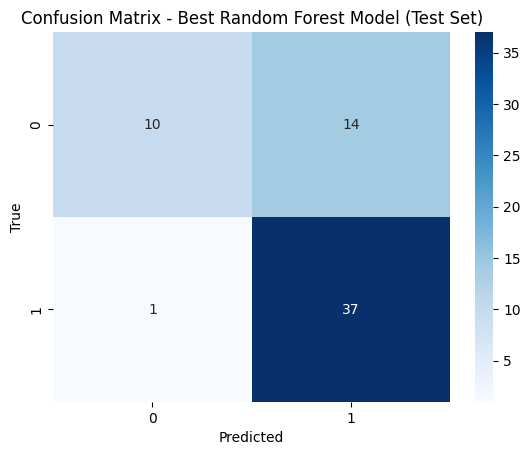

In [25]:
# Index of the Random Forest model in the list of model names
rf_model_index = model_names.index('Random Forest')

# Retrieving the best Random Forest model from the best_models list
best_rf_model = best_models[rf_model_index]

# Testing the best-performing Random Forest model on the test data
y_pred_test_rf = best_rf_model.predict(X_test_scaled)

# Classification report for the test set
print("Classification Report - Best Random Forest Model (Test Set):")
print(classification_report(y_test, y_pred_test_rf, target_names=['N', 'Y']))

# Confusion matrix heatmap for the test set
cm_test_rf = confusion_matrix(y_test, y_pred_test_rf)
sns.heatmap(cm_test_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Best Random Forest Model (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



###Results

1. The model achieved an accuracy of 0.76, meaning it correctly predicted the loan approval status for approximately 76% of the instances in the test set.
2.   The precision for class 'N' is 0.91, indicating that when the model predicted 'N' (not approved), it was correct 91% of the time. The precision for class 'Y' is 0.73, indicating that when the model predicted 'Y' (approved), it was correct 73% of the time.
3. The recall for class 'N' is 0.42, suggesting that the model only identified 42% of the actual 'N' instances. The recall for class 'Y' is 0.97, indicating that the model correctly identified 97% of the actual 'Y' instances.
4. The F1-score for class 'N' is 0.57, and for class 'Y' is 0.83. These scores provide a balance between precision and recall for each class.


The Random Forest model has good precision and recall for predicting the 'Y' class (loan approval), suggesting that it's able to accurately identify applicants who are likely to get approved for loans.
The precision for class 'Y' is higher than class 'N', indicating that when the model predicts an applicant will get approved, it's more likely to be accurate.
The recall for class 'Y' is high as well, meaning that the model is able to capture a significant proportion of actual loan approvals.
The F1-score balances both precision and recall, providing a holistic view of the model's effectiveness.

###Analyzing Feature Importance

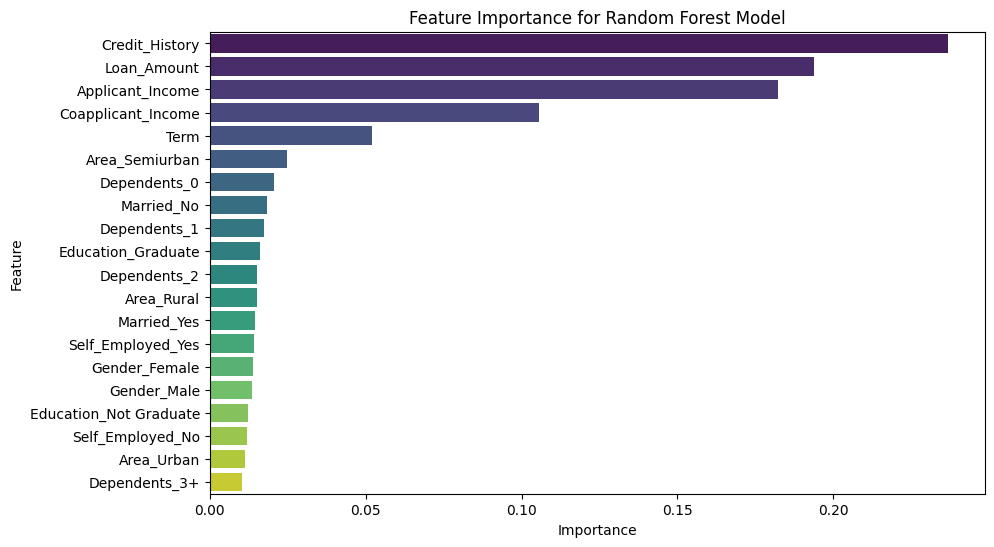

In [26]:
feature_importances = best_rf_model.feature_importances_

# Creating a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sorting the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Model')
plt.show()
